# Action Graph 

### Goals:

- A graph store/database to store and trace any computations during eager execution
- Graph that works with the current in memory worker
- Ability to visualize the graph
- Generate a dependecy list of node, so that any dependeny action can be generated
- Basic query/search functionalities
- Locking/Concurrency

In [1]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService, NodeActionDataUpdate, ExecutionStatus
from syft.service.action.action_graph import InMemoryActionGraphStore, InMemoryGraphConfig, InMemoryStoreClientConfig

from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/shubham/PySyft


## Scenario for performing some computation

```python

import syft as sy

domain_client = sy.login("....")

dataset = domain_client.datasets[0]

a = dataset.assets["A"]

b = dataset.assets["B"]

c = a + b

d = domain_client.api.numpy.array([1, 2, 3])

e = c * d

# Inplace operation, mutated the value of d
d.astype('int32')

f = d + 48
```

<br>
<br>

**Corresponding Actions Generated**

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d + 48

```

![graph.png](graph.png)

### Initializing the Store

In [2]:
# Create a Config

store_config = InMemoryGraphConfig()

In [3]:
# Initialize the InMemory Store

graph_store = InMemoryActionGraphStore(store_config=store_config)

In [4]:
G = graph_store.graph.db

### Initializing Action Graph Service

In [5]:
action_graph_service = ActionGraphService(store=graph_store)

In [6]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

In [7]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

### Create some dummy data

In [8]:
labels_dict = {}

In [9]:
action_obj_a = ActionObject.from_obj([2, 4, 6])
action_obj_b = ActionObject.from_obj([2, 3, 4])

In [10]:
labels_dict[action_obj_a.id] = "A"
labels_dict[action_obj_b.id] = "B"

In [11]:
action_obj_a.id, action_obj_b.id

(<UID: 0366dd11596d42468fff475b3a9fc363>,
 <UID: aa260e9604d64f4c966e2dce37db6d54>)

In [12]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_a)

```python
class NodeActionData:
  id: str = 0366dd11596d42468fff475b3a9fc363
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:31
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [13]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_b)

```python
class NodeActionData:
  id: str = aa260e9604d64f4c966e2dce37db6d54
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:31
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

### Action1 -> A + B

In [14]:
action1 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action_obj_a.syft_lineage_id,
    args=[action_obj_b.syft_lineage_id],
    kwargs={}
)
action1

```python
class Action:
  id: str = 6d7c0a4d565241008453f9aa0773f2a4
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = 0366dd11596d42468fff475b3a9fc363
  args: str = [<LineageID: aa260e9604d64f4c966e2dce37db6d54 - 549054868221716451>]
  kwargs: str = {}
  result_id: str = 854900f02b9143049666dcf097643fb1

```

In [15]:
labels_dict[action1.id] = "+"
labels_dict[action1.result_id.id] = "C"

### Save action to Graph

In [16]:
# action_graph_service.add_action

In [17]:
action_graph_service.add_action(context=authed_context, action=action1)

(class NodeActionData:
   id: str = 6d7c0a4d565241008453f9aa0773f2a4
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:33
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = 854900f02b9143049666dcf097643fb1
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:33
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

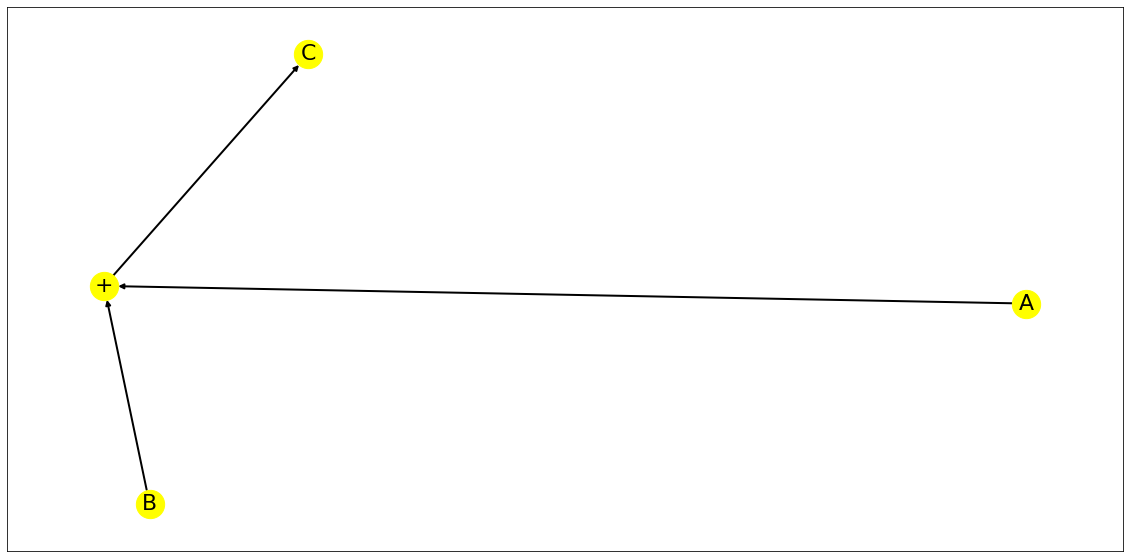

In [18]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

### Action2 -> np.array([1, 2, 3])

In [19]:
action_obj_d = ActionObject.from_obj([1, 2, 3])

In [20]:
labels_dict[action_obj_d.id] = "[1, 2 ,3]"

In [21]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_d)

```python
class NodeActionData:
  id: str = e96fe39ec9ed4b10a22d22542361a3e9
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:35
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [22]:
# Create Action2

action2 = Action(
    path="action.execute",
    op="np.array",
    remote_self=None,
    args=[action_obj_d.syft_lineage_id],
    kwargs={}
)
action2

```python
class Action:
  id: str = 89acd56940d24644b783841609c44c17
  path: str = "action.execute"
  op: str = "np.array"
  remote_self: str = None
  args: str = [<LineageID: e96fe39ec9ed4b10a22d22542361a3e9 - 985232007473396904>]
  kwargs: str = {}
  result_id: str = 2fffea40da1a4f2ab984281c7aefc1e0

```

In [23]:
labels_dict[action2.id] = "np.array"
labels_dict[action2.result_id.id] = "D"

In [24]:
# Save action to graph
action_graph_service.add_action(context=authed_context, action=action2)

(class NodeActionData:
   id: str = 89acd56940d24644b783841609c44c17
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:36
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = 2fffea40da1a4f2ab984281c7aefc1e0
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:36
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

In [25]:
# 747749f9494345b78e165f13351e52bf: {"data": NodeActionData()}

In [26]:
action1.result_id.id

<UID: 854900f02b9143049666dcf097643fb1>

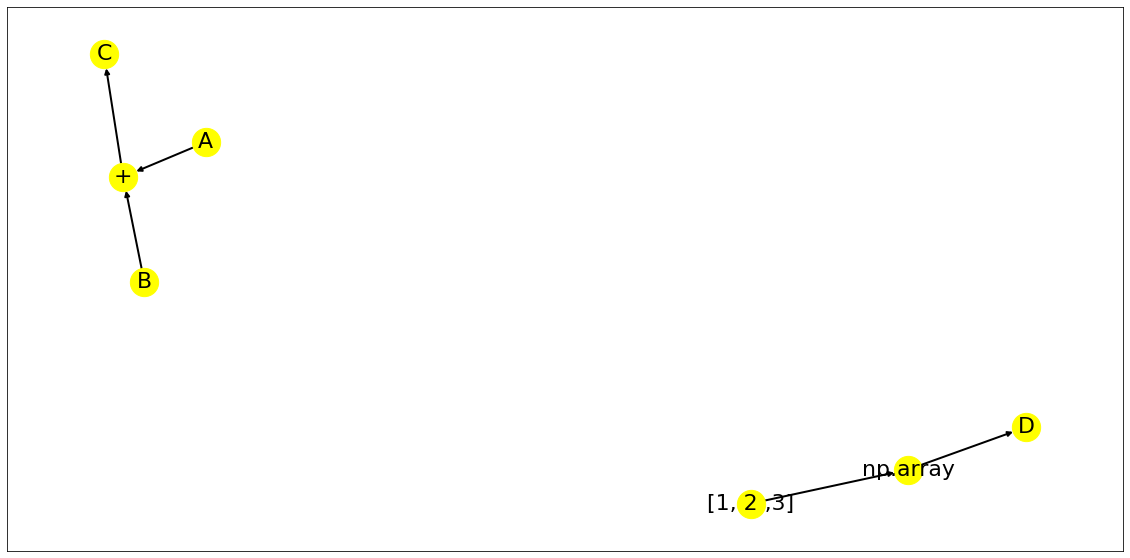

In [27]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

### Action3 -> C * D

In [28]:
action3 = Action(
    path="action.execute",
    op="__mul__",
    remote_self=action1.result_id,
    args=[action2.result_id],
    kwargs={}
)
action3

```python
class Action:
  id: str = 4c19f9f38dd4479297ef4b8b020110d1
  path: str = "action.execute"
  op: str = "__mul__"
  remote_self: str = 854900f02b9143049666dcf097643fb1
  args: str = [<LineageID: 2fffea40da1a4f2ab984281c7aefc1e0 - 1838447364910758721>]
  kwargs: str = {}
  result_id: str = 51b874d3437c40daa652d3089bc836e0

```

In [29]:
action_graph_service.add_action(context=authed_context, action=action3)

(class NodeActionData:
   id: str = 4c19f9f38dd4479297ef4b8b020110d1
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:39
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = 51b874d3437c40daa652d3089bc836e0
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:39
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

In [30]:
labels_dict[action3.id] = "*"
labels_dict[action3.result_id.id] = "E"

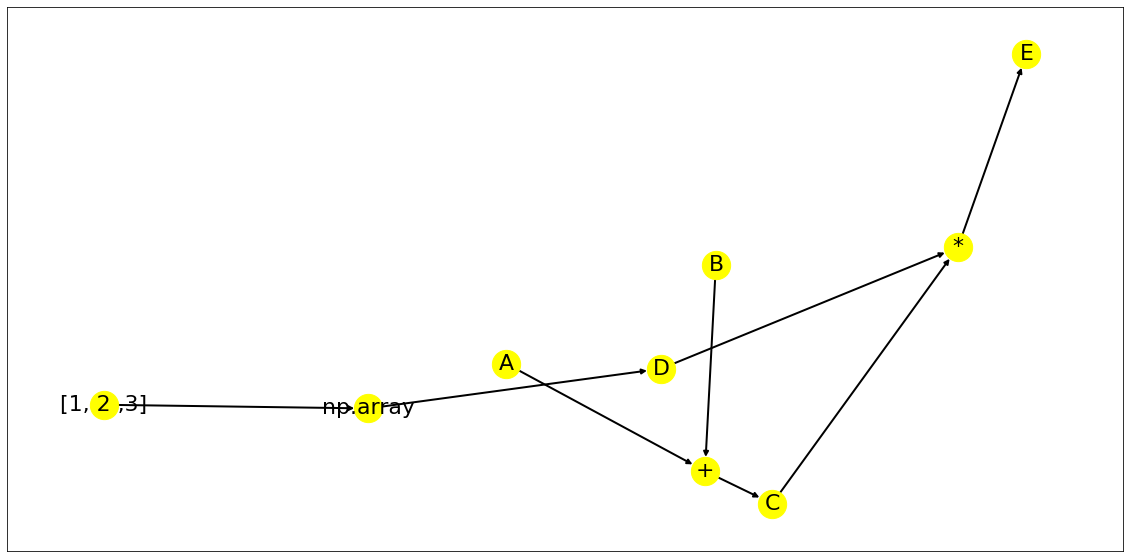

In [31]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794651)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

### Action4 -> Mutate type of D

In [32]:
as_type_action_obj = ActionObject.from_obj('np.int32')

In [33]:
action_graph_service.add_action_obj(context=authed_context, action_obj=as_type_action_obj)

```python
class NodeActionData:
  id: str = 053183e4242044c491ca2aa10ddd9701
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:41
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [34]:
labels_dict[as_type_action_obj.id] = "np.int32"

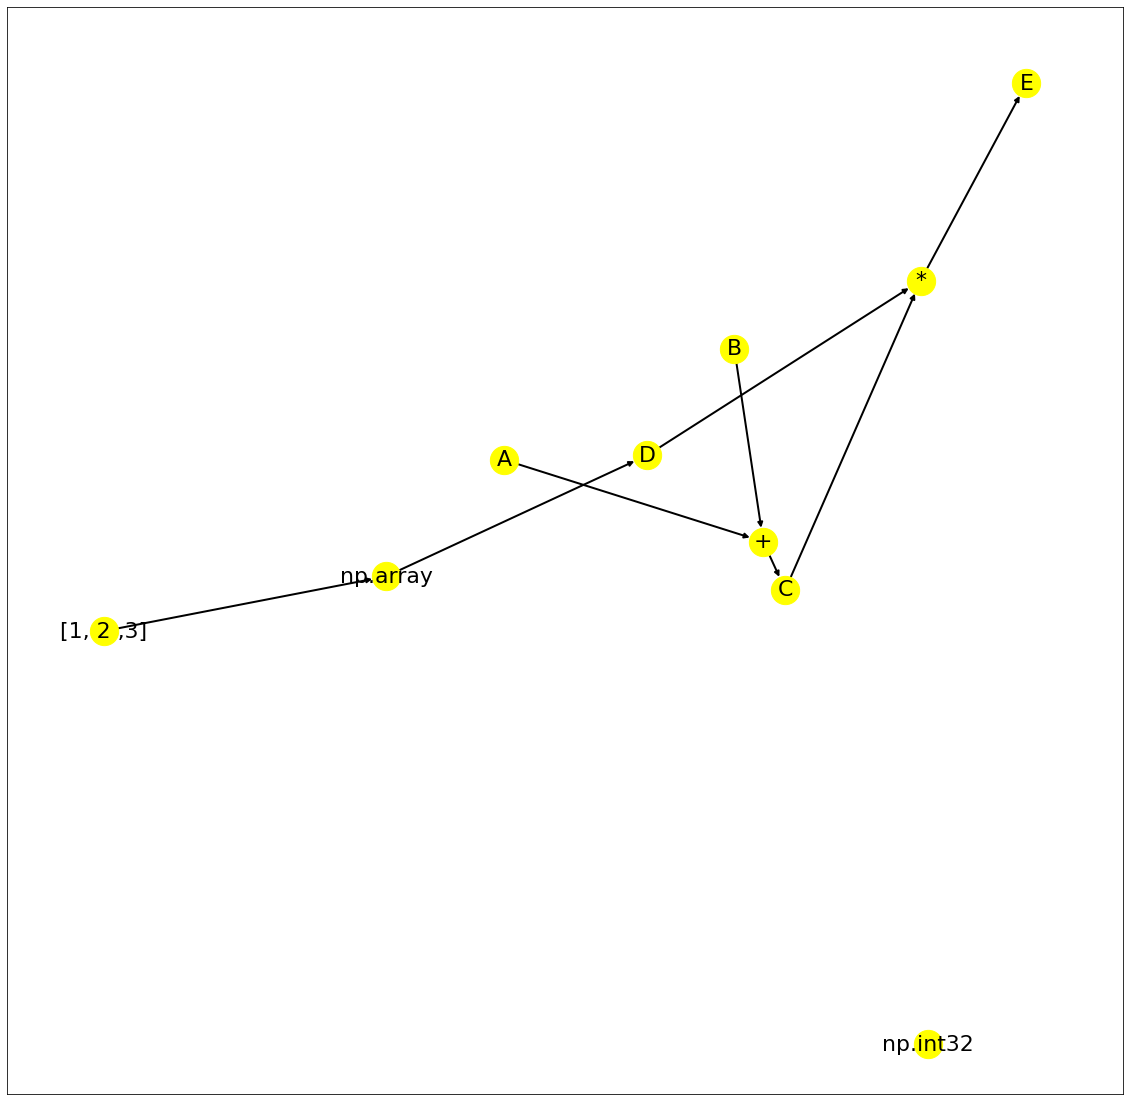

In [35]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, seed=3113794651)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

In [36]:
action4 = Action(
    path="action.execute",
    op="astype",
    remote_self=action2.result_id,
    args=[as_type_action_obj.syft_lineage_id],
    kwargs={},
    result_id=action2.result_id
)
action4

```python
class Action:
  id: str = c6544ae371164b96ba9a84651bca477b
  path: str = "action.execute"
  op: str = "astype"
  remote_self: str = 2fffea40da1a4f2ab984281c7aefc1e0
  args: str = [<LineageID: 053183e4242044c491ca2aa10ddd9701 - 1969842985380068646>]
  kwargs: str = {}
  result_id: str = 2fffea40da1a4f2ab984281c7aefc1e0

```

In [37]:
action_graph_service.add_action(context=authed_context, action=action4)

(class NodeActionData:
   id: str = c6544ae371164b96ba9a84651bca477b
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:43
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = True
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = None
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:36
   updated_at: str = 2023-05-03 09:47:43
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = True
   is_mutagen: str = False
   next_mutagen_node: str = c6544ae371164b96ba9a84651bca477b
   last_nm_mutagen_node: str = c6544ae371164b96ba9a84651bca477b)

In [38]:
labels_dict[action4.id] = "astype"

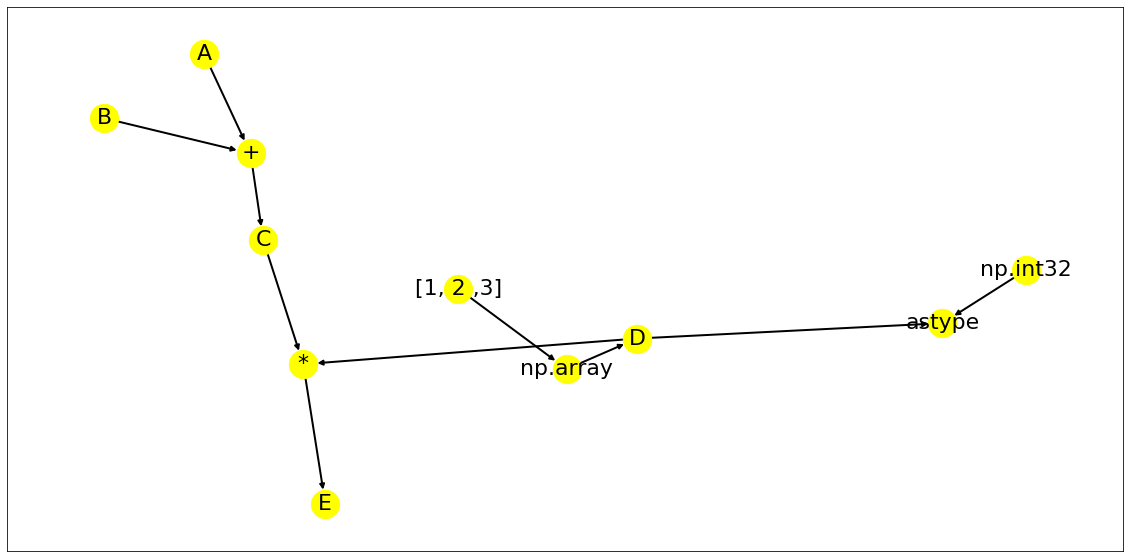

In [39]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)

In [40]:
mid = G.nodes(data=True)[action2.result_id.id]["data"]['next_mutagen_node']
mid

<UID: c6544ae371164b96ba9a84651bca477b>

In [41]:
G.nodes(data=True)[action2.result_id.id]['data']

```python
class NodeActionData:
  id: str = None
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:36
  updated_at: str = 2023-05-03 09:47:43
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = True
  is_mutagen: str = False
  next_mutagen_node: str = c6544ae371164b96ba9a84651bca477b
  last_nm_mutagen_node: str = c6544ae371164b96ba9a84651bca477b

```

In [42]:
G.nodes(data=True)[mid]['data'].id == action4.id

True

In [43]:
G.nodes(data=True)[action4.id]['data']

```python
class NodeActionData:
  id: str = c6544ae371164b96ba9a84651bca477b
  type: str = NodeType.ACTION
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:43
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = True
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

#### Action5 -> D[0] = 10

In [44]:
idx_action_obj = ActionObject.from_obj(0)
action_graph_service.add_action_obj(context=authed_context, action_obj=idx_action_obj)

```python
class NodeActionData:
  id: str = c7cf119637794921824bbf5723cb7328
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:46
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [45]:
labels_dict[idx_action_obj.id] = "0"

In [46]:
item_val_action_obj = ActionObject.from_obj(10)
action_graph_service.add_action_obj(context=authed_context, action_obj=item_val_action_obj)

```python
class NodeActionData:
  id: str = c191e858e222405196c2306ca7eb2e8f
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:46
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [47]:
labels_dict[item_val_action_obj.id] = "10"

In [48]:
action5 = Action(
    path="action.execute",
    op="__setitem__",
    remote_self=action2.result_id,
    args=[idx_action_obj.syft_lineage_id, item_val_action_obj.syft_lineage_id],
    kwargs={},
    result_id=action2.result_id
)
action5

```python
class Action:
  id: str = ecda3f7fc423445390c512bc98fabd19
  path: str = "action.execute"
  op: str = "__setitem__"
  remote_self: str = 2fffea40da1a4f2ab984281c7aefc1e0
  args: str = [<LineageID: c7cf119637794921824bbf5723cb7328 - 55252696429870182>, <LineageID: c191e858e222405196c2306ca7eb2e8f - 239098921211474252>]
  kwargs: str = {}
  result_id: str = 2fffea40da1a4f2ab984281c7aefc1e0

```

In [49]:
action5.remote_self.id

<UID: 2fffea40da1a4f2ab984281c7aefc1e0>

<UID: 973923ce1d0a4fd287e4430969461420>

In [50]:
action_graph_service.add_action(context=authed_context, action=action5)

Node id: 2fffea40da1a4f2ab984281c7aefc1e0
NM Successor ecda3f7fc423445390c512bc98fabd19
Node id: c6544ae371164b96ba9a84651bca477b
NM Successor ecda3f7fc423445390c512bc98fabd19


(class NodeActionData:
   id: str = ecda3f7fc423445390c512bc98fabd19
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:58
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = True
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = None
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:47:43
   updated_at: str = 2023-05-03 09:47:58
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = True
   is_mutagen: str = True
   next_mutagen_node: str = ecda3f7fc423445390c512bc98fabd19
   last_nm_mutagen_node: str = ecda3f7fc423445390c512bc98fabd19)

In [51]:
labels_dict[action5.id] = "__setitem__"

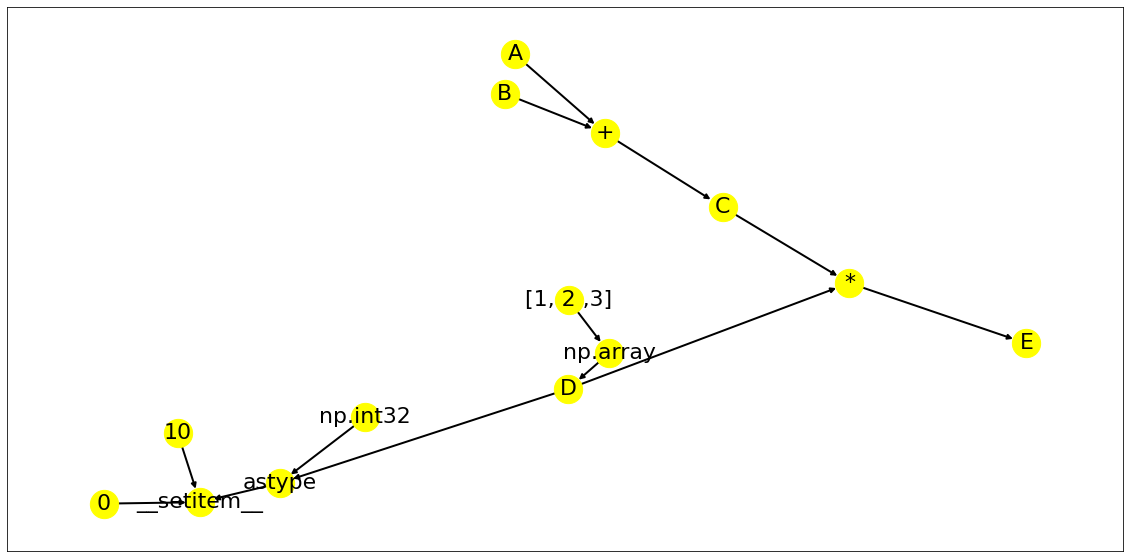

In [52]:
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(G, seed=3113794652)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=800, font_size=22)


### Action6 -> D + 48

In [53]:
arg_action_obj = ActionObject.from_obj(48)

In [54]:
action_graph_service.add_action_obj(context=authed_context, action_obj=arg_action_obj)

```python
class NodeActionData:
  id: str = 38c19ab1d76f43a4989a3d3a6117556d
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:48:20
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None

```

In [55]:
labels_dict[arg_action_obj.id] = "48"

In [56]:
# action2.result_id == action4.result_id

In [57]:
G.nodes(data=True)

NodeDataView({<UID: 0366dd11596d42468fff475b3a9fc363>: {'data': class NodeActionData:
  id: str = 0366dd11596d42468fff475b3a9fc363
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:31
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None
}, <UID: aa260e9604d64f4c966e2dce37db6d54>: {'data': class NodeActionData:
  id: str = aa260e9604d64f4c966e2dce37db6d54
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-03 09:47:31
  updated_at: str = None
  user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
  is_mutated: str = False
  is_mutagen: str = False
  next_mutagen_node: str = None
  last_nm_mutagen_node: str = None
}, <UID

In [58]:
action6 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action2.result_id,
    args=[arg_action_obj.syft_lineage_id],
    kwargs={},
)
action6

```python
class Action:
  id: str = c84229655a1c4a00b12f1e4f0051e644
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = 2fffea40da1a4f2ab984281c7aefc1e0
  args: str = [<LineageID: 38c19ab1d76f43a4989a3d3a6117556d - 2208754797225538207>]
  kwargs: str = {}
  result_id: str = 8faec97dafd1487f889049957abf9f11

```

In [59]:
action_graph_service.add_action(context=authed_context, action=action6)

(class NodeActionData:
   id: str = c84229655a1c4a00b12f1e4f0051e644
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:48:26
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None,
 class NodeActionData:
   id: str = 8faec97dafd1487f889049957abf9f11
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-03 09:48:26
   updated_at: str = None
   user_verify_key: str = 4203dff854f61d2fae74d7c33f6b19bab97d3368df74e1d6ec3e82ff02fb9e92
   is_mutated: str = False
   is_mutagen: str = False
   next_mutagen_node: str = None
   last_nm_mutagen_node: str = None)

In [60]:
labels_dict[action6.id] = "+"
labels_dict[action6.result_id.id] = "F"

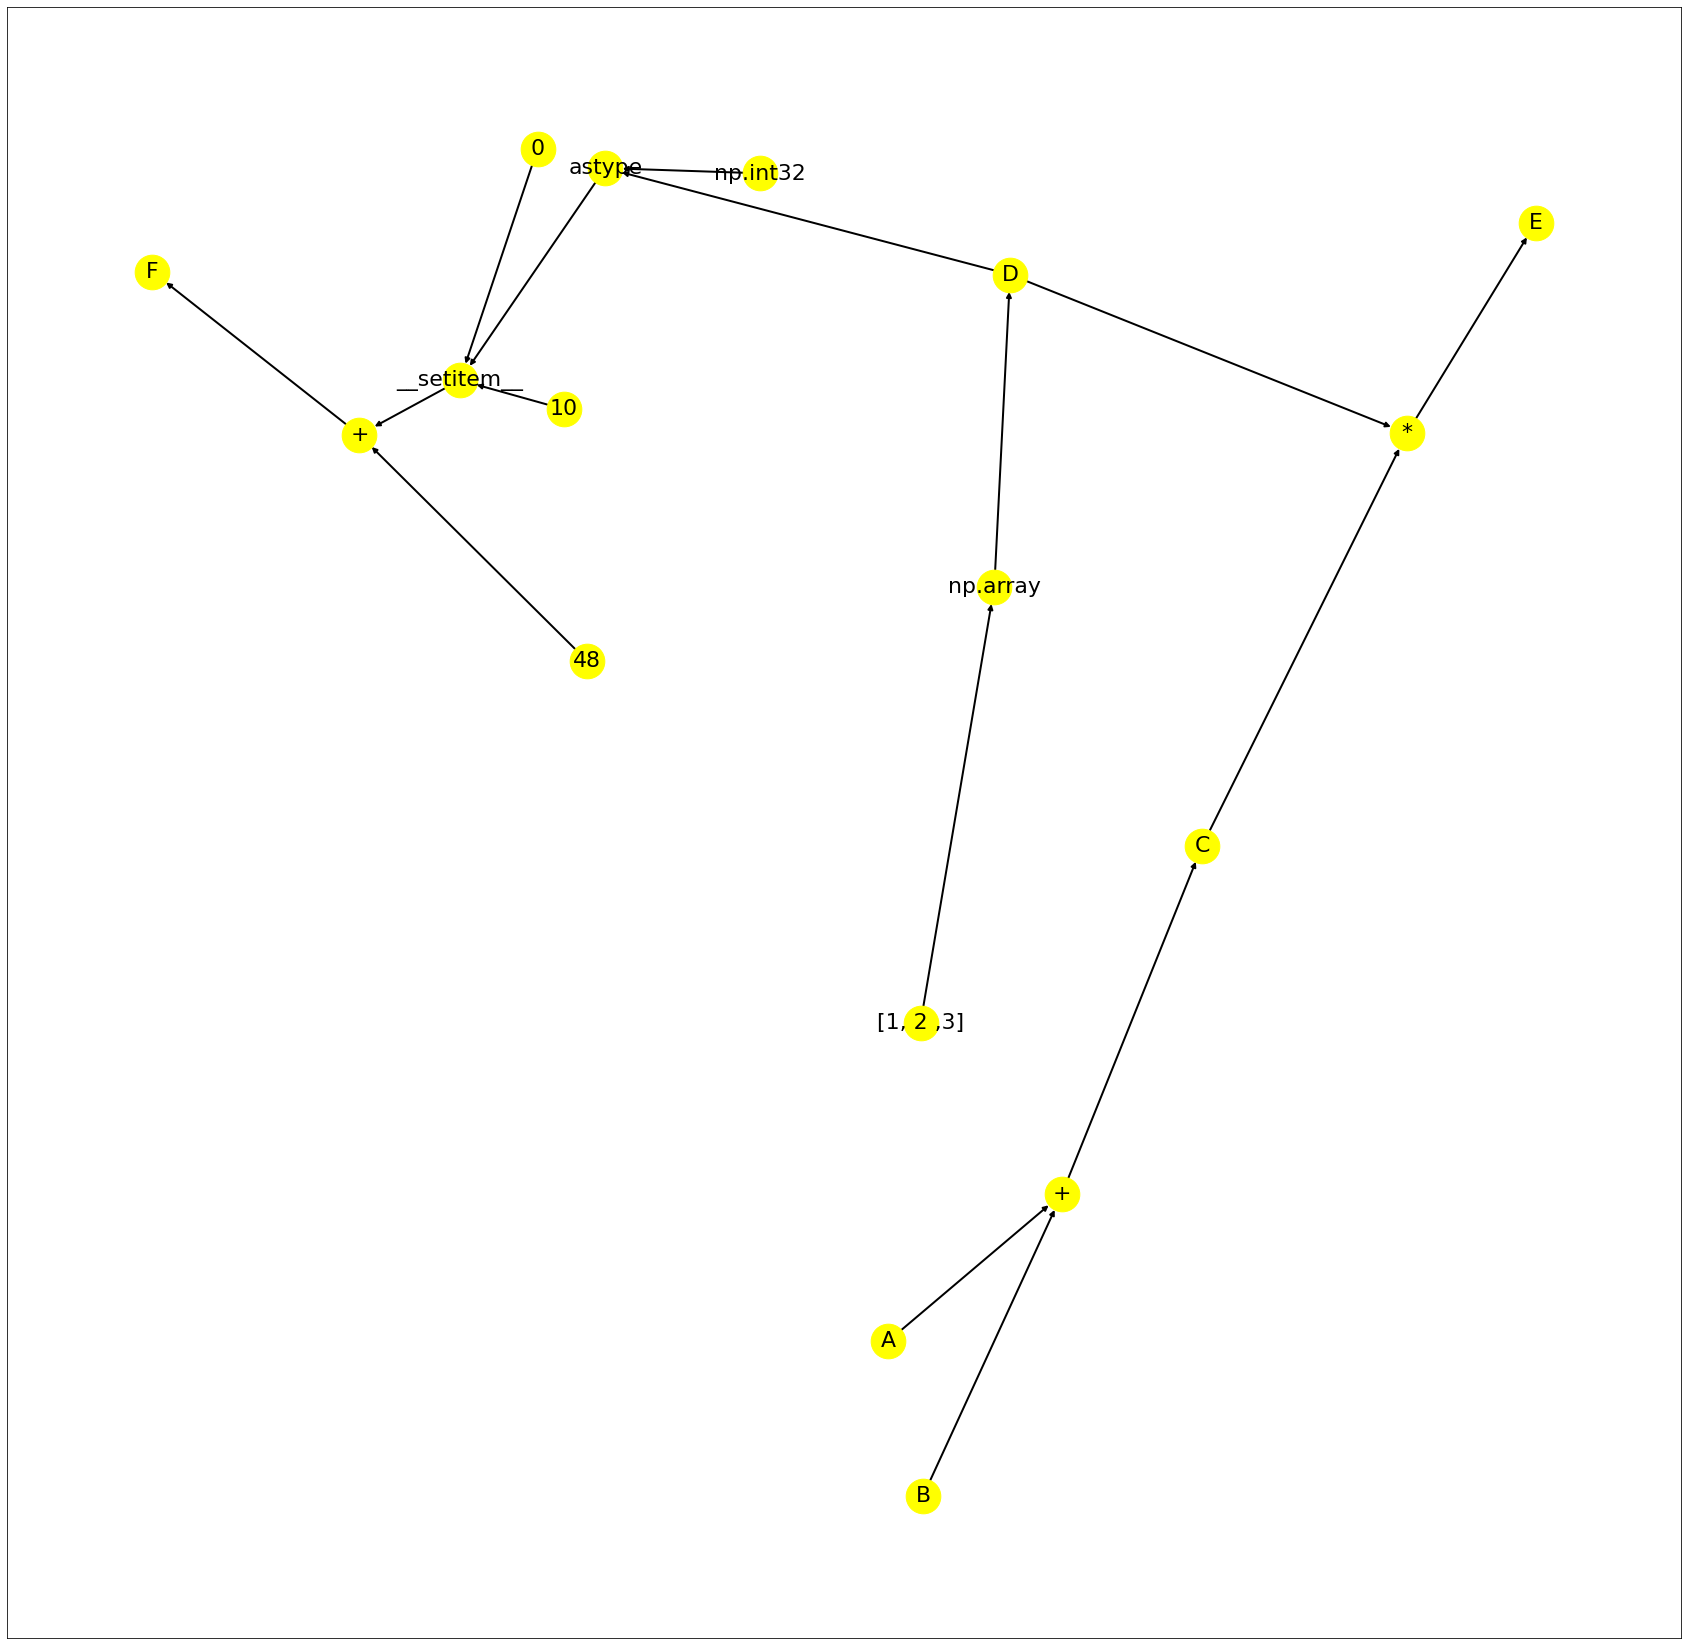

In [61]:
plt.figure(figsize=(30, 30))
pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos=pos)
nx.draw_networkx(G, pos=pos, labels=labels_dict, with_labels=True, width=2.0, node_color="yellow", node_size=1200, font_size=22)

In [62]:
labels_dict.values()

dict_values(['A', 'B', '+', 'C', '[1, 2 ,3]', 'np.array', 'D', '*', 'E', 'np.int32', 'astype', '0', '10', '__setitem__', '48', '+', 'F'])

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d[0] = 10

action6 -> d + 48

```

## Filtering Actions in the Graph

### Filter by ActionStatus

```
ActionStatus
- PROCESSING
- DONE
- FAILED
```

In [ ]:
action_graph_service.get_by_action_status(context=authed_context, status=ActionStatus.PROCESSING)

In [ ]:
action_graph_service.get_by_action_status(context=authed_context, status=ActionStatus.DONE)

### Filter by Particular User

In [ ]:
action_graph_service.get_by_verify_key(context=authed_context, verify_key=signing_key.verify_key)

In [ ]:
### Serde 

In [ ]:
# bytes_data = sy.serialize(graph_store, to_bytes=True)

In [ ]:
# graph_store = sy.deserialize(bytes_data, from_bytes=True)